In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive, config_enumerate
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    interval_outlier,
    detrend,
    ffnn_input_vector,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/data/eigil/work/premis


In [2]:
def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse

In [3]:
df_em = default_em()

lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}
df = load_uplift(timefreq="W")
df_tmp = df.copy()
df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
y_train = detrend(up_kuaq)
df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [4]:
df

,Time,Thickness,Up_kuaq,Up_mik2
0,2009-08-09,-71.119454,-123.248500,-82.948714
1,2009-08-16,-71.119454,-120.074429,-82.948714
2,2009-08-23,70.358415,-118.587286,-80.912571
3,2009-08-30,-156.756184,-116.760857,-78.976143
4,2009-09-06,-243.902582,-115.254857,-78.106857
...,...,...,...,...
539,2019-12-08,36.997695,83.572000,65.858000
540,2019-12-15,35.788532,84.766143,66.201800
541,2019-12-22,34.627839,81.964714,60.577714
542,2019-12-29,29.403177,80.600286,58.727429


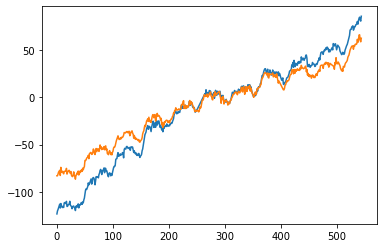

In [5]:
plt.plot(up_kuaq)
plt.plot(up_mik2)

<AxesSubplot:>

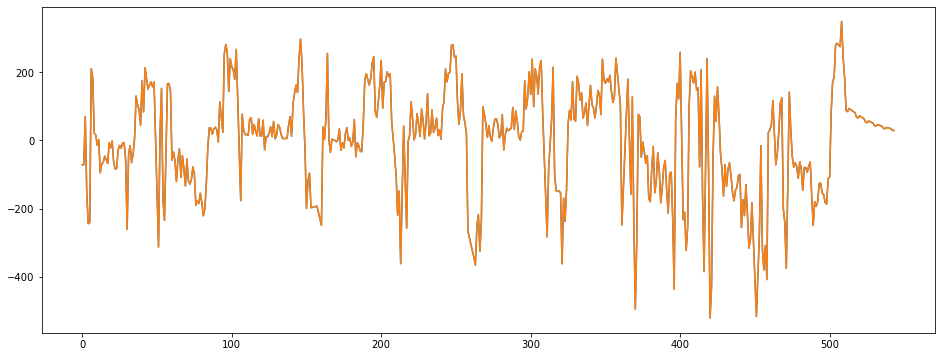

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, height)
df.Thickness.plot()

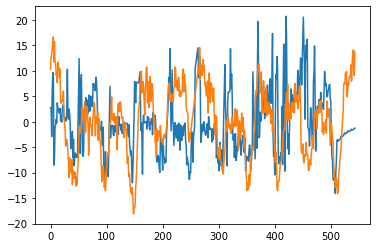

In [7]:
gf_test = -2e-4
tmp = height - np.mean(height)  # / np.std(height)
tmp2 = y_train
tmp2 = tmp2 - np.mean(tmp2)  # / np.std(tmp2)
plt.plot(2e2 * tmp * gf_test)
plt.plot(tmp2)

## For train test split, one hot encoded month numbers are included for later use in second model

In [8]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [9]:
standardized_height = height - np.mean(height)  # / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X = torch.tensor(X_cat).float()

y1 = torch.tensor(detrend(up_kuaq)).float()
y1 = y1 - y1.mean()  # / y_train1.std()

y2 = torch.tensor(detrend(up_mik2)).float()
y2 = y2 - y2.mean()  # / y_train2.std()

y = torch.vstack([y1, y2]).T

In [10]:
train_perc = 0.80  # percentage of training data
split_point = int(train_perc * len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
# X_time_train = X_time[ix_train,:]
# X_time_test = X_time[ix_test,:]
X_train = X[ix_train, :]
X_test = X[ix_test, :]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 435
num test: 109


## load neural network to estimate love numbers

In [11]:
df_params, x = ffnn_input_vector(
    df_em, path="../data/processed/ffnn_variable_normalisation_params_512.csv"
)

ffnn = FFNN(31, 200, 513)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v2.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=513, bias=True)
  (relu): ReLU()
)

In [12]:
logmean = np.log10(5e10) / np.log10(np.exp(1))
logscale = np.log10(10) / np.log10(np.exp(1))
print(f"{logmean} {logscale}")
sigma_w = pyro.sample("tmp", dist.LogNormal(logmean * torch.ones(2000), 0.4))
# sigma_w = 1e11 * pyro.sample("tmp", dist.Exponential(torch.ones(2000)))
sigma_w.numpy()

24.635288842374557 2.302585092994046


array([8.0136135e+10, 2.9011651e+10, 3.0092407e+10, ..., 6.4752796e+10,
       3.7200859e+10, 5.4431408e+10], dtype=float32)

In [13]:
f"{sigma_w.numpy().min():e} {sigma_w.numpy().max():e}"

'1.217953e+10 2.083837e+11'

<AxesSubplot:ylabel='Density'>

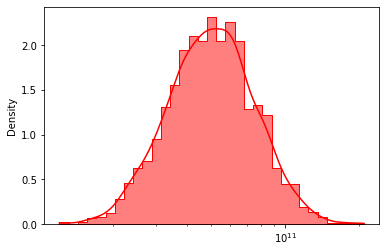

In [14]:
sns.histplot(
    # 1e11 + 1e10 * samples[node],
    sigma_w,
    kde=True,
    stat="density",
    element="step",
    color="red",
    log_scale=True,
)

In [15]:
def model(X, x, df_params, obs=None, df_em=None):
    N = len(X)
    K = 2
    seasonality = 12 # months
    t = torch.linspace(0, 1, N)

    # seasonality modelling
    alpha_s = pyro.sample("alpha_s", dist.Normal(0., 1.))
    sigma_s = pyro.sample("sigma_s", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2)))

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )

    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))
    
    # Draw target
    with pyro.plate("data", K, dim=-1):
        w = pyro.sample(
            "w", dist.Normal(gf * X[:, 0][..., None], torch.exp(alpha_s + X[:, 1:].matmul(sigma_s))), obs=obs
        )
    return w

In [16]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, y_train, df_em)

Sample: 100%|██████████| 1100/1100 [02:03,  8.91it/s, step size=1.29e-01, acc. prob=0.905]


In [17]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_s      1.80      0.19      1.79      1.52      2.13     25.61      1.00
rigidity_1[0] 33658433536.00 18787678208.00 29762191360.00 8094905856.00 57869262848.00   1091.39      1.00
rigidity_2[0] 44440014848.00 24018288640.00 39415189504.00 14246647808.00 80969023488.00   1181.11      1.00
 sigma_s[0,0]     -0.16      0.22     -0.17     -0.49      0.22     32.44      1.00
 sigma_s[0,1]     -0.27      0.21     -0.27     -0.59      0.10     34.27      1.00
 sigma_s[1,0]     -0.17      0.23     -0.17     -0.56      0.18     39.20      1.00
 sigma_s[1,1]     -0.33      0.22     -0.34     -0.72      0.00     34.89      1.00
 sigma_s[2,0]      0.20      0.22      0.21     -0.19      0.52     34.98      1.00
 sigma_s[2,1]     -0.17      0.22     -0.17     -0.53      0.19     34.57      1.01
 sigma_s[3,0]      0.27      0.22      0.28     -0.12      0.60     37.21      1.00
 sigma_s[3,1]      0.06   

In [19]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_0 = np.mean(1 / 15 * (A[0] + C[0] - 2 * F[0] + 5 * N[0] + 6 * L[0]))
prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_0": prem_rigidity_0 * 1e8,
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

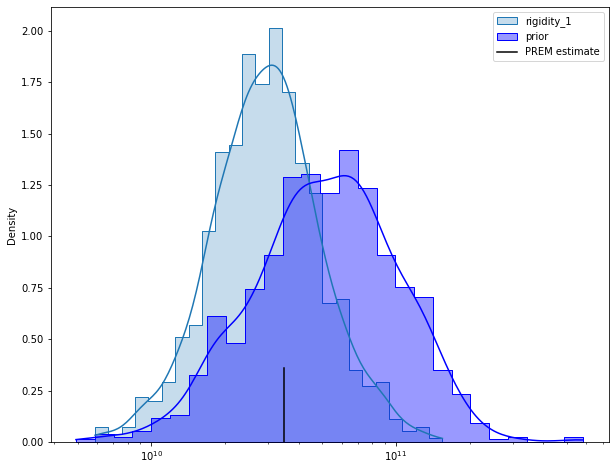

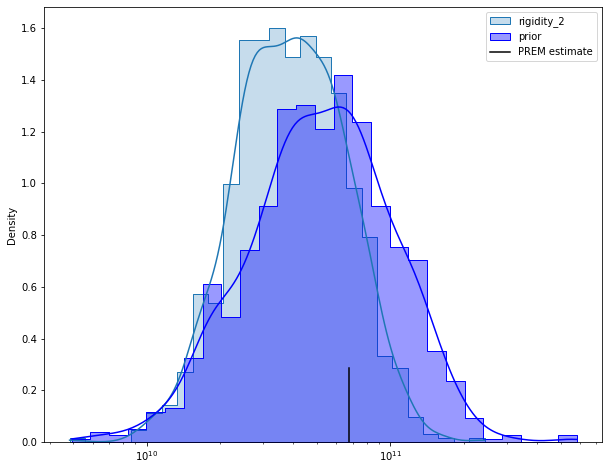

In [118]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(10, 8))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.savefig("./ch3_{}_dist.png".format(node), dpi=400)
    plt.show()
    

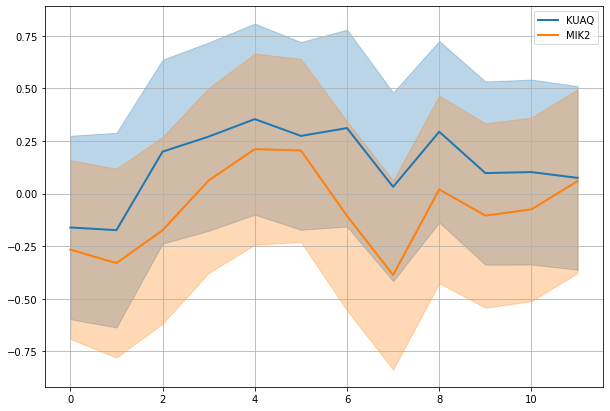

In [116]:
sigma_s_mu = samples["sigma_s"].mean(axis=0)
sigma_s_std =samples["sigma_s"].std(axis=0)

plt.figure(figsize=(10,7))
plt.plot(sigma_s_mu[:, 0], lw=2, label="KUAQ")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 0] - 2.0 * sigma_s_std[:, 0]).numpy(),
            (sigma_s_mu[:, 0] + 2.0 * sigma_s_std[:, 0]).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(sigma_s_mu[:, 1], lw=2, label="MIK2")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 1] - 2.0 * sigma_s_std[:, 1]).numpy(),
            (sigma_s_mu[:, 1] + 2.0 * sigma_s_std[:, 1]).numpy(),
            color="C1",
            alpha=0.3,
        )
plt.legend()
plt.grid()
plt.savefig("./ch3_seasonality_sigma_s.png", dpi=400)

(2000,)


/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


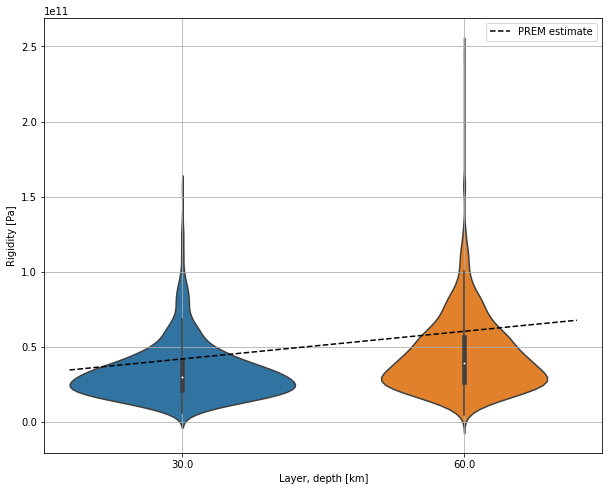

In [117]:
rigidity_list = []
prem_rigidity_list = [prem_rigidity["rigidity_0"]]
for node in nodes:
    rigidity_list.append(samples[node].numpy())
    prem_rigidity_list.append(prem_rigidity[node])
    
layers = np.hstack((30 * np.ones(1000), 60 * np.ones(1000)))
print(layers.shape)
df_layers = pd.DataFrame(np.array([np.vstack(rigidity_list).squeeze(), layers]).T, 
                         columns=["Rigidity [Pa]", "Layer, depth [km]"])

plt.figure(figsize=(10,8))
sns.violinplot(x = "Layer, depth [km]", y = "Rigidity [Pa]", data = df_layers)
sns.lineplot([-0.4, 1.4], prem_rigidity_list[1:], color="black", linestyle="--", label="PREM estimate")
plt.grid('minor')
plt.savefig("ch3_violin.png", dpi=400)

### Compare to observations

In [92]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


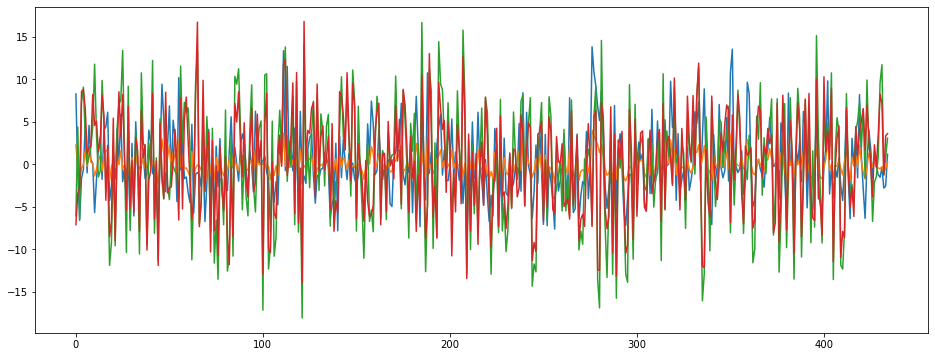

In [93]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["w"].mean(axis=0))
plt.plot(y_train[:, 0])
plt.plot(y_train[:, 1])

In [94]:
predictive["gf"].mean(axis=0)

tensor([[-0.0264, -0.0075]])

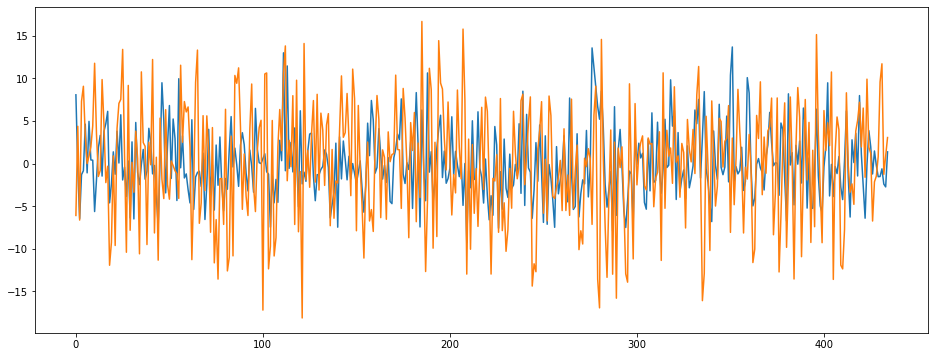

In [95]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["gf"].mean(axis=0)[0, 0] * X_train[:,0])
plt.plot(y_train[:, 0])

In [96]:
posterior_samples = mcmc.get_samples()

In [97]:
predictive["gf"].mean(axis=0).shape

torch.Size([1, 2])

In [98]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:,0].reshape(109,1)

In [99]:
y_hat.shape

torch.Size([109, 2])

In [100]:
corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: -1.000
MAE: 4.880
RAE: 0.928
RMSE: 5.985


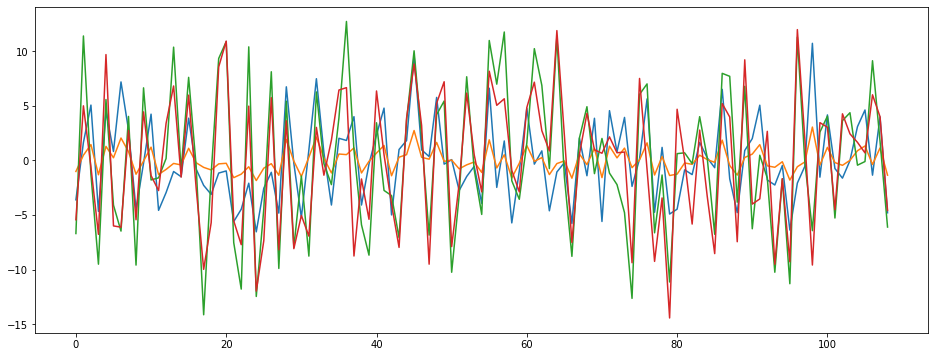

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(y_hat)
plt.plot(y_test)

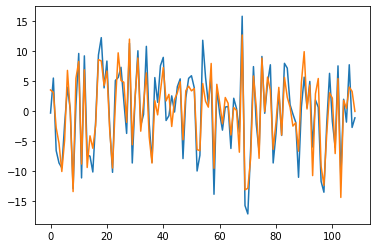

In [ ]:
plt.plot(y_test)

In [34]:
w_pred = (-gf_res * X_train[:, 0]).mean(axis=0)
plt.plot(y_train)
plt.plot(w_pred)
corr, mae, rae, rmse = compute_error(y_train.numpy(), w_pred.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

NameError: name 'gf_res' is not defined